## 格式转换

In [ ]:
import os
import SimpleITK
import numpy as np
import cv2
from tqdm import tqdm
import shutil
 
def convert_from_dicom_to_jpg(img,low_window,high_window,save_path):
    lungwin = np.array([low_window*1.,high_window*1.])
    newimg = (img-lungwin[0])/(lungwin[1]-lungwin[0])    #归一化
    newimg = (newimg*255).astype('uint8')                #将像素值扩展到[0,255]
    stacked_img = np.stack((newimg,) * 3, axis=-1)
    cv2.imwrite(save_path, stacked_img, [int(cv2.IMWRITE_JPEG_QUALITY), 100])
 
if __name__ == '__main__':
	#dicom文件目录
    dicom_dir = '/home/ubuntu/data/CT_data/normal/0t2/Dong Li Jun Zhi Zi78486289/20210106141722/601'
 
    path = "/home/ubuntu/data/CT_Data/"
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path)

    for i in tqdm(os.listdir(dicom_dir)):
        dcm_image_path = os.path.join(dicom_dir,i)  # 读取dicom文件
        name, _ = os.path.splitext(i)
        output_jpg_path = os.path.join(path, name+'.png')
        ds_array = SimpleITK.ReadImage(dcm_image_path)  # 读取dicom文件的相关信息
        img_array = SimpleITK.GetArrayFromImage(ds_array)  # 获取array
        # SimpleITK读取的图像数据的坐标顺序为zyx，即从多少张切片到单张切片的宽和高，此处我们读取单张，因此img_array的shape
        # 类似于 （1，height，width）的形式
        shape = img_array.shape
        img_array = np.reshape(img_array, (shape[1], shape[2]))  # 获取array中的height和width
        high = np.max(img_array)
        low = np.min(img_array)
        convert_from_dicom_to_jpg(img_array, low, high, output_jpg_path)  # 调用函数，转换成jpg文件并保存到对应的路径

## 边缘提取

### 边缘检测结果

In [38]:
##canny检测算子
import os
import numpy as np
import cv2
src_dir='/home/ubuntu/data_process/contour/N_unet'
files = os.listdir(src_dir)
i=0
for s in files:
    img = cv2.imread(src_dir + '/' + s, 0)
    ret2, th2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    N_Otus=cv2.Canny(th2, 50, 100, (3, 3))
    img_path = "/home/ubuntu/data_process/CT_Result/N/" + s
    cv2.imwrite(img_path, N_Otus) 
    i+=1

(Text(0.5, 1.0, 'N_Otus'), ([], []), ([], []))

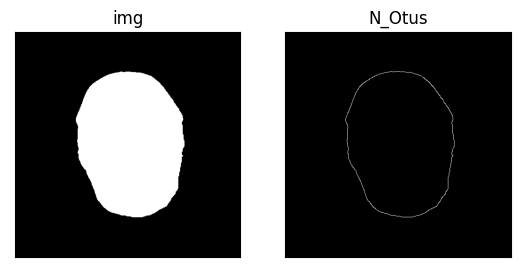

In [37]:
# /home/ubuntu/DeepLearning/U-net/Pytorch-UNet/N_grey_OUT.png
import os
import numpy
import cv2

img = cv2.imread("/home/ubuntu/data_process/contour/N_unet/N.6.png",0)
ret2, th2 = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
N_Otus=cv2.Canny(th2, 50, 100, (3, 3))


# img = cv2.imread('/home/ubuntu/data_process/contour/C/C_Otus.2.png')
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# mask = cv2.threshold(gray, 20, 255, cv2.THRESH_BINARY)[1]

plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('img'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(N_Otus,cmap = 'gray')
plt.title('N_Otus'), plt.xticks([]), plt.yticks([])


### 区域生长算法

In [9]:

import numpy as np
import cv2

class Point(object):
    def __init__(self,x,y):
        self.x = x
        self.y = y
 
    def getX(self):
        return self.x
    def getY(self):
        return self.y
 
def getGrayDiff(img,currentPoint,tmpPoint):
    return abs(int(img[currentPoint.x,currentPoint.y]) - int(img[tmpPoint.x,tmpPoint.y]))
 
def selectConnects(p):
    if p != 0:
        connects = [Point(-1, -1), Point(0, -1), Point(1, -1), Point(1, 0), Point(1, 1), \
                    Point(0, 1), Point(-1, 1), Point(-1, 0)]
    else:
        connects = [ Point(0, -1),  Point(1, 0),Point(0, 1), Point(-1, 0)]
    return connects
 
def regionGrow(img,seeds,thresh,p = 1):
    height, weight = img.shape
    seedMark = np.zeros(img.shape)
    seedList = []
    for seed in seeds:
        seedList.append(seed)
    label = 1
    connects = selectConnects(p)
    while(len(seedList)>0):
        currentPoint = seedList.pop(0)
 
        seedMark[currentPoint.x,currentPoint.y] = label
        for i in range(8):
            tmpX = currentPoint.x + connects[i].x
            tmpY = currentPoint.y + connects[i].y
            if tmpX < 0 or tmpY < 0 or tmpX >= height or tmpY >= weight:
                continue
            grayDiff = getGrayDiff(img,currentPoint,Point(tmpX,tmpY))
            if grayDiff < thresh and seedMark[tmpX,tmpY] == 0:
                seedMark[tmpX,tmpY] = label
                seedList.append(Point(tmpX,tmpY))
    return seedMark
 
 
img = cv2.imread('/home/ubuntu/data_process/contour/N/N_.2141.png',0)
# img_save_path='/home/ubuntu/data_process/result'
seeds = [Point(10,10),Point(82,150),Point(20,300)]
binaryImg = regionGrow(img,seeds,10)
# cv2.imshow(' ',binaryImg)
# # cv2.waitKey(0)
# imsave(img_save_path, binaryImg)
# plt.subplot(121),plt.imshow(canny_OTU,cmap = 'gray')
# plt.title('canny_OTU'), plt.xticks([]), plt.yticks([])
# plt.subplot(122),plt.imshow(binaryImg,cmap = 'gray')
# plt.title('OUTIMAGE'), plt.xticks([]), plt.yticks([])

(Text(0.5, 1.0, 'canny_OTU'), ([], []), ([], []))

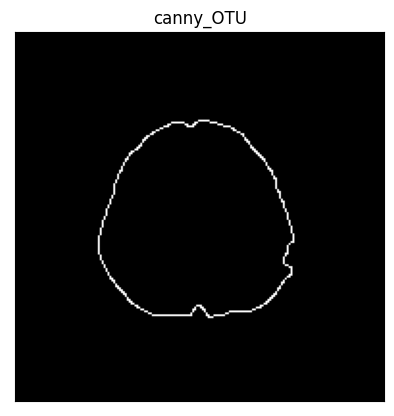

In [18]:
import matplotlib.pyplot as plt
import cv2
img = cv2.imread('/home/ubuntu/DeepLearning/U-net/Pytorch-UNet/N_grey_OUT.png')
# ret2, th2 = cv2.threshold(binaryImg, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
canny_OTU=cv2.Canny(img, 50, 100, (3, 3))
# img_path = "/home/ubuntu/data_process/CT_Result/N/" + "N_."+".png"
# cv2.imwrite(img_path, binaryImg*255) 
plt.subplot(111),plt.imshow(canny_OTU,cmap = 'gray')
plt.title('canny_OTU'), plt.xticks([]), plt.yticks([])

### 最大联通区域

(Text(0.5, 1.0, 'OUTIMAGE'), ([], []), ([], []))

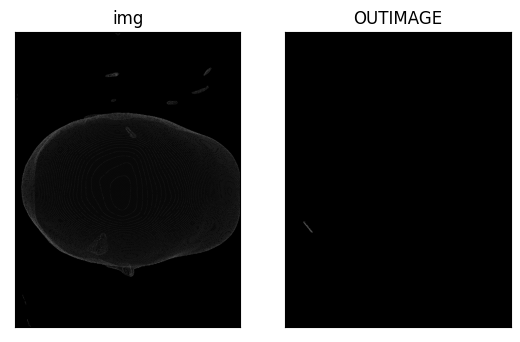

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def select_max_region(mask):
    nums, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)
    background = 0
    for row in range(stats.shape[0]):
        if stats[row, :][0] == 0 and stats[row, :][1] == 0:
            background = row
    stats_no_bg = np.delete(stats, background, axis=0)
    max_idx = stats_no_bg[:, 4].argmax()
    max_region = np.where(labels==max_idx+1, 1, 0)

    return max_region


img = cv2.imread('/home/ubuntu/data_process/3D_T_2D/ply_png/selected_head_model_roi.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
mask = cv2.threshold(gray, 20, 255, cv2.THRESH_BINARY)[1]
mask = select_max_region(mask)*255
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('img'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(mask,cmap = 'gray')
plt.title('OUTIMAGE'), plt.xticks([]), plt.yticks([])
# cv2.imwrite('/Users/nickccnie/Desktop/images1.png', mask*255)


In [51]:
### 批量处理并保存到文件夹
#批量处理
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt


def select_max_region(mask):
    nums, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)
    background = 0
    for row in range(stats.shape[0]):
        if stats[row, :][0] == 0 and stats[row, :][1] == 0:
            background = row
    stats_no_bg = np.delete(stats, background, axis=0)
    max_idx = stats_no_bg[:, 4].argmax()
    max_region = np.where(labels==max_idx+1, 1, 0)

    return max_region

src_dir='/home/ubuntu/data_process/CT_Result/N_unet'
files = os.listdir(src_dir)
i=0
for s in files:
    img = cv2.imread(src_dir + '/' + s, 0)
    # img = cv2.imread('/home/ubuntu/data_process/contour/C_Otus.10.png')
    # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # mask = cv2.threshold(img, 20, 255, cv2.THRESH_BINARY)[1]
    mask =cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
    mask = select_max_region(mask)*255
    img_path = "/home/ubuntu/data_process/CT_Result/N/" + s
    cv2.imwrite(img_path, mask) 
    i+=1

In [23]:
import cv2
# import matplotlib.pyplot as plt

import os
#read image

src_dir='/home/ubuntu/data_process/dcm_2_png/N'
files = os.listdir(src_dir)
i=0
for s in files:
# Otsu阈值 自动获取全局阈值,即无需手动决定阈值大小,阈值thresh大小默认0即可
    img_grey = cv2.imread(src_dir + '/' + s, cv2.IMREAD_GRAYSCALE)
    ret,otsu_thresh1 = cv2.threshold(img_grey,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    save_path="/home/ubuntu/data_process/dataset/N/"+"N."+str(i)+'.png'
    cv2.imwrite(save_path,otsu_thresh1)
    i+=1

NameError: name 's' is not defined

## 图片相似查询

In [ ]:
import cv2
import numpy as np
import os
img1 = cv2.imread('/home/ubuntu/data_process/CT_Result/C/C_11.png', 0)
ret, thresh1 = cv2.threshold(img1, 127, 255, 0)
contours, hierarchy = cv2.findContours(thresh1, 2, 1)
cnt1 = contours[0]
src_dir='/home/ubuntu/data_process/CT_Result/C'
files = os.listdir(src_dir)
i=0
for s in files:
    img2 = cv2.imread(src_dir + '/' + s, 0)
    ret, thresh2 = cv2.threshold(img2, 127, 255, 0)
    contours, hierarchy = cv2.findContours(thresh2, 2, 1)
    cnt2 = contours[0]
    ret = cv2.matchShapes(cnt1, cnt2, 1, 0.0)
    # img = cv2.imread('/home/ubuntu/data_process/contour/C_Otus.10.png')
    # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 越相近，数越小，轮廓大小最好相当
    if ret<0.2:
       print("ret"+str(i),ret)
       img_path = "/home/ubuntu/data_process/dataset/C/" + "C_"+str(i) +".png"
       cv2.imwrite(img_path, img2)
       
    i+=1
    

In [137]:
#制作mask
import os
import cv2
import numpy as np
   # 1.导入图片
# img_src = cv2.imread('/home/ubuntu/DeepLearning/U-net/Pytorch-UNet/data/masks/C.0_mask.png')
src_dir='/home/ubuntu/data_process/CT_Result/N_raw'
files = os.listdir(src_dir)
i=0
for s in files:
    img = cv2.imread(src_dir + '/' + s)
       # 2.灰度处理与二值化
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, img_bin = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY)
     # 3.连通域分析
    contours, hierarchy = cv2.findContours(img_bin, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

    # 4.制作掩膜图片
    img_mask = np.zeros(img.shape, np.uint8)
    img_result=cv2.drawContours(img_mask, contours, -1, (0, 0, 255), -1)
    img_path = "/home/ubuntu/data_process/CT_Result/N/" + s
    cv2.imwrite(img_path, img_result) 
    i+=1

In [67]:
img = cv2.imread("/home/ubuntu/data_process/result.png")
       # 2.灰度处理与二值化
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, img_bin = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY)
     # 3.连通域分析
contours, hierarchy = cv2.findContours(img_bin, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

    # 4.制作掩膜图片
img_mask = np.zeros(img_src.shape, np.uint8)
img_result=cv2.drawContours(img_mask, contours, -1, (0, 0, 255), -1)

cv2.imwrite("/home/ubuntu/data_process/test1.png", img_result) 

True

In [58]:
#opencv判断图像轮廓是否闭合
import cv2
import os
import numpy as np
def dContoursIsClose(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, img_bin = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(img_bin, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
    fatherContoursNum = 0
    for i in range(len(hierarchy[0])):
        if hierarchy[0][i][3] == -1:
            fatherContoursNum += 1
            if hierarchy[0][i][2] == -1:
                return False
        else:
            if hierarchy[0][i][3] > len(hierarchy[0]):
                return False
            if i == hierarchy[0][hierarchy[0][i][3]][2]:
                pass
            else:
                return False
    if fatherContoursNum != (len(hierarchy[0]) // 2):
        return False
    return True
src_dir='/home/ubuntu/data_process/CT_Result/C_1'
files = os.listdir(src_dir)

for s in files:
    if dContoursIsClose(src_dir + '/' + s):
        img = cv2.imread(src_dir + '/' + s)
        img_path = "/home/ubuntu/data_process/CT_Result/C/" + s
        cv2.imwrite(img_path, img) 
  

In [60]:
len(os.listdir("/home/ubuntu/data_process/CT_Result/C"))

4493

In [133]:
#保存编号相同的文件
import os
import re
import shutil
# 获取第一个目录中的所有图像文件名
path1='/home/ubuntu/data_process/data/imgs'
path2='/home/ubuntu/data_process/data/masks'
out_path='/home/ubuntu/data/mask_result'
folder1_images = [f for f in os.listdir(path1) if os.path.isfile(os.path.join(path1, f)) ]

# 获取第二个目录中的所有图像文件名
folder2_images = [f for f in os.listdir(path2) if os.path.isfile(os.path.join(path2, f)) ]


# 定义一个正则表达式，用于提取文件名中的编号
pattern = re.compile(r'(\d+)')

# 将文件名相同的文件放入一个列表中
same_name_images = []
for image1 in folder1_images:
    for image2 in folder2_images:
        if pattern.search(image1).group(1) == pattern.search(image2).group(1):
            same_name_images.append((image1, image2))
            break


# 创建一个新目录来保存同名文件
# os.makedirs('path/to/new_folder', exist_ok=True)

# 复制同名文件到新目录
for image1,image2  in same_name_images:
    image2_path = os.path.join(path2, image2)
    shutil.copy(image2_path, out_path)


In [156]:
#删除图像与mask大小不一致的图片
import os
import re
import shutil


path1='/home/ubuntu/DeepLearning/U-net/Pytorch-UNet/data/imgs'
path2='/home/ubuntu/DeepLearning/U-net/Pytorch-UNet/data/masks'
# out_path='/home/ubuntu/data/mask_result'
folder1_images = [f for f in os.listdir(path1) if os.path.isfile(os.path.join(path1, f)) ]

# 获取第二个目录中的所有图像文件名
folder2_images = [f for f in os.listdir(path2) if os.path.isfile(os.path.join(path2, f)) ]


# 定义一个正则表达式，用于提取文件名中的编号
pattern = re.compile(r'(\d+)')

# 将文件名相同的文件放入一个列表中
same_name_images = []
for image1 in folder1_images:
    for image2 in folder2_images:
        if pattern.search(image1).group(1) == pattern.search(image2).group(1):
            same_name_images.append((image1, image2))
            break


# 创建一个新目录来保存同名文件
# os.makedirs('path/to/new_folder', exist_ok=True)

# 复制同名文件到新目录
for image1,image2  in same_name_images:
    image1_path = os.path.join(path1, image1)
    image2_path = os.path.join(path2, image2)
    size1=cv2.imread(image1_path).shape
    size2=cv2.imread(image2_path).shape
    if size1 != size2:
       os.remove(image1_path)
       os.remove(image2_path)
    # cv2.imread(image1_path).shape[1]
        


In [56]:
#删除图像与mask大小不一致的图片
import os
import re
import shutil
src_dir="/home/ubuntu/data_process/CT_Result/C"
files = os.listdir(src_dir)
for s in files:
   
   size = cv2.imread(src_dir + '/' + s).shape
   if size != (512,512,3):
       os.remove(src_dir + '/' + s)
    # cv2.imread(image1_path).shape[1]

In [57]:
len(os.listdir("/home/ubuntu/data_process/CT_Result/C"))

4490

In [63]:
import os
import cv2
import numpy as np

folder_path = '/home/ubuntu/data_process/CT_Result/C_raw'

contour_sizes = []
for filename in os.listdir(folder_path):
    if filename.endswith('.jpg') or filename.endswith('.png'): # 检查文件是否为图像文件
        img = cv2.imread(os.path.join(folder_path, filename))
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, thresh = cv2.threshold(gray, 127, 255, 0)
        contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for cnt in contours:
            contour_sizes.append(cv2.contourArea(cnt))

# 计算所有轮廓大小的平均值和标准差
mean_size = np.mean(contour_sizes)
std_size = np.std(contour_sizes)
print('Mean contour size:', mean_size)
print('Standard deviation of contour size:', std_size)


Mean contour size: 60987.71845092366
Standard deviation of contour size: 27558.01662158359


In [66]:
len(contour_sizes)

4493

In [68]:
len(os.listdir("/home/ubuntu/data_process/CT_Result/C_raw"))

4493

In [69]:
import os
import cv2
import openpyxl

# 设置输入文件夹路径和输出Excel文件路径
input_folder = "/home/ubuntu/data_process/CT_Result/C_raw"
output_file = "/home/ubuntu/data_process/CT_Result/file.xlsx"

# 创建一个Excel工作簿
workbook = openpyxl.Workbook()
worksheet = workbook.active

# 遍历文件夹中的所有图片文件
for filename in os.listdir(input_folder):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        # 读取图片并转为灰度图像
        img = cv2.imread(os.path.join(input_folder, filename))
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # 使用Canny算子进行边缘检测
        edges = cv2.Canny(gray, 100, 200)
        
        # 使用findContours函数计算轮廓大小
        contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        total_size = 0
        for cnt in contours:
            total_size += cv2.contourArea(cnt)
        
        # 将图片名称和轮廓大小保存到Excel表格中
        row = (filename, total_size)
        worksheet.append(row)

# 保存Excel文件
workbook.save(output_file)


3031


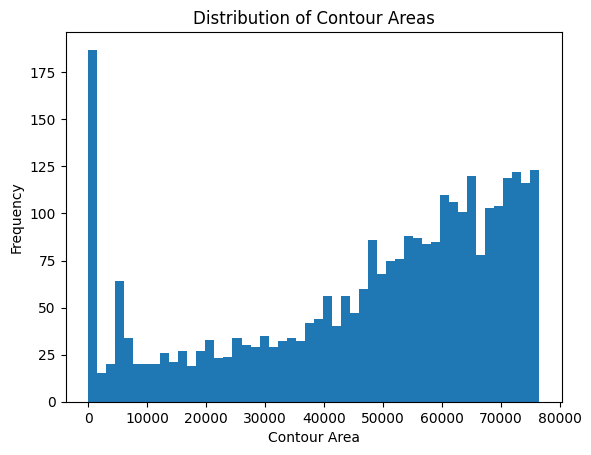

In [141]:
import os
import cv2
import pandas as pd

# 文件夹路径和输出Excel文件名
folder_path = '/home/ubuntu/data_process/CT_Result/C_raw'
output_file = '/home/ubuntu/data_process/CT_Result/file.xlsx'

# 获取文件夹中的所有图像文件名
image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# 存储每个图像的名称和对应的轮廓面积
image_areas = []

# 循环遍历每个图像文件，计算轮廓大小并添加到列表中
for filename in image_files:
    # 读取图像并将其转换为灰度图像
    img = cv2.imread(os.path.join(folder_path, filename), cv2.IMREAD_GRAYSCALE)

    # 计算轮廓并提取其面积
    contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    area = cv2.contourArea(contours[0])

    # 将图像名称和轮廓面积添加到列表中
    image_areas.append({'Filename': filename, 'Contour Area': area})

# 将结果保存到Excel文件中
df = pd.DataFrame(image_areas)
df.to_excel(output_file, index=False)
print(len(os.listdir("/home/ubuntu/data_process/CT_Result/C_raw")))
# 绘制面积分布规律图
import matplotlib.pyplot as plt
plt.hist(df['Contour Area'], bins=50)
plt.xlabel('Contour Area')
plt.ylabel('Frequency')
plt.title('Distribution of Contour Areas')
plt.show()


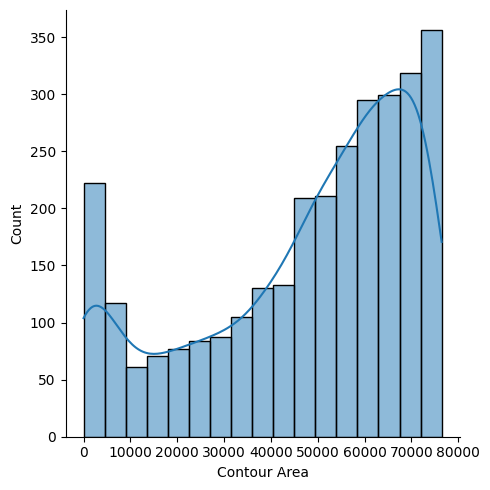

In [142]:
import pandas as pd
import seaborn as sns
image_folder="/home/ubuntu/data_process/CT_Result/C_raw"
# 从Excel文件中读取数据
df = pd.read_excel('/home/ubuntu/data_process/CT_Result/file.xlsx')

# 绘制面积分布规律图
sns.displot(data=df, x='Contour Area', kde=True)

# 删除面积值为样本极端值的图片
threshold1 = df['Contour Area'].quantile(0.75)
threshold2 = df['Contour Area'].quantile(0.25)
# threshold2 = df['Contour Area'].quantile(0.25)
outliers = df[(df['Contour Area'] > df['Contour Area'].quantile(0.75)) | (df['Contour Area'] < df['Contour Area'].quantile(0.25))]
for filename in outliers['Filename']:
    os.remove(os.path.join(image_folder, filename))


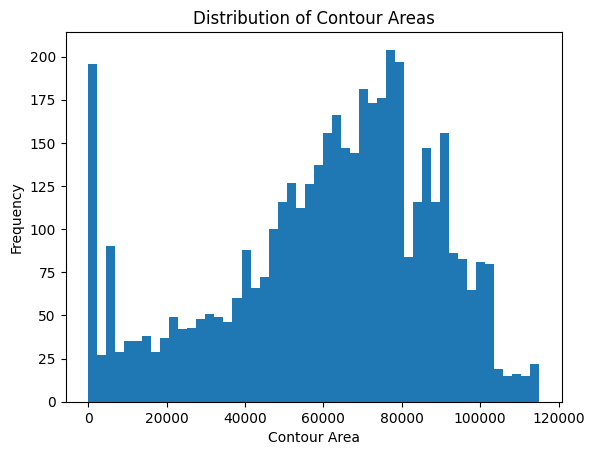

In [87]:
import matplotlib.pyplot as plt
plt.hist(df['Contour Area'], bins=50)
plt.xlabel('Contour Area')
plt.ylabel('Frequency')
plt.title('Distribution of Contour Areas')
plt.show()

In [94]:
# /home/ubuntu/data_process/CT_Result/C_raw/C_7332.png
img = cv2.imread("/home/ubuntu/data_process/CT_Result/C_raw/C_7327.png", cv2.IMREAD_GRAYSCALE)

    # 计算轮廓并提取其面积
contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
area = cv2.contourArea(contours[0])

In [95]:
area

72416.5

In [131]:
import cv2
import numpy as np

#坐标距离法

def distance_based_similarity(cnt1, cnt2):
    # 计算两个轮廓之间的距离
    d = cv2.matchShapes(cnt1, cnt2, cv2.CONTOURS_MATCH_I1, 0.0)
    return d


# 动态时间规整法（DTW）
def dtw_similarity(cnt1, cnt2):
    # 计算两个轮廓之间的距离矩阵
    dist_matrix = np.zeros((len(cnt1), len(cnt2)))
    for i in range(len(cnt1)):
        for j in range(len(cnt2)):
            dist_matrix[i, j] = cv2.norm(cnt1[i], cnt2[j], cv2.NORM_L2)

    # 计算最小距离路径
    cum_dist = np.zeros((len(cnt1), len(cnt2)))
    cum_dist[0, 0] = dist_matrix[0, 0]
    for i in range(1, len(cnt1)):
        cum_dist[i, 0] = cum_dist[i-1, 0] + dist_matrix[i, 0]
    for j in range(1, len(cnt2)):
        cum_dist[0, j] = cum_dist[0, j-1] + dist_matrix[0, j]
    for i in range(1, len(cnt1)):
        for j in range(1, len(cnt2)):
            cum_dist[i, j] = dist_matrix[i, j] + min(cum_dist[i-1, j], cum_dist[i, j-1], cum_dist[i-1, j-1])

    # 计算距离
    d = cum_dist[-1, -1] / (len(cnt1) + len(cnt2))
    return d


# 轮廓点的形状上下文（Shape Context of Contour Points）
def shape_context_similarity(cnt1, cnt2):
    # 计算形状上下文特征
    extractor = cv2.createShapeContextDistance()
    sc1=extractor.computeDistance(cnt1, cnt1)
    sc2 =extractor.computeDistance(cnt2, cnt2)

    # 计算形状上下文距离
    d = cv2.compareHist(sc1, sc2, cv2.HISTCMP_CHISQR_ALT)
    return d

# 模板匹配（Template Matching）
def template_matching_similarity(cnt1, cnt2):
    # 计算轮廓外接矩形
    x1, y1, w1, h1 = cv2.boundingRect(cnt1)
    x2, y2, w2, h2 = cv2.boundingRect(cnt2)

    # 裁剪轮廓区域
    roi1 = cnt1[y1:y1+h1, x1:x1+w1]
    roi2 = cnt2[y2:y2+h2, x2:x2+w2]

    # 缩放轮廓
    roi1 = cv2.resize(roi1, roi2.shape[::-1])
    



# 示例用法
img1 = cv2.imread('/home/ubuntu/data_process/CT_Result/C_raw/C_7214.png',0)
img2 = cv2.imread('/home/ubuntu/data_process/CT_Result/C_raw/C_1649.png',0)
d1=distance_based_similarity(img1,img2)
print(d1)

0.12248532706584014


In [2]:
import cv2

# 读取彩色图片
img_color = cv2.imread('/home/ubuntu/DeepLearning/U-net/Pytorch-UNet/111.jpg')

# 转换为灰度图片
img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)

# 保存灰度图片
cv2.imwrite('/home/ubuntu/DeepLearning/U-net/Pytorch-UNet/111gray.jpg', img_gray)


True